In [62]:
import numpy as np
import math
from utils import draw_dot

In [159]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None  
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"



# NOTE: Backpropagation is an iterative application of the chain rule.

# NOTE: If we use a variable more than once in the graph, we need to accumualte the 
# gradients. Thats why in _backwards(), we need to use '+=' instead of only '='.

In [160]:
a = Value(1.2, label = 'a')
b = Value(1.0, label = 'b')
c = a*b
d = c.tanh()
e = d**2

In [150]:
e.backward()


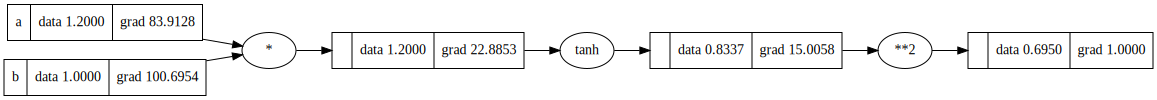

In [151]:
draw_dot(e)

In [163]:
-1 - e - 1

Value(data=-2.694980003792591, grad=0.0)

In [239]:
class Neuron:

    def __init__(self, number_inputs: int):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(number_inputs)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        #w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"TanhNeuron({len(self.w)})"

class Layer:
    def __init__(self, number_inputs: int, number_outputs: int):
        self.neurons = [Neuron(number_inputs) for _ in range(number_outputs)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP:

    def __init__(self, number_inputs: int, number_outputs: list):
        sz = [number_inputs] + number_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(number_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [240]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9574047423763409, grad=0.0)

In [241]:
l = Layer(4, 5)
l(x)

[Value(data=-0.9992914088321623, grad=0.0),
 Value(data=-0.0962497518808506, grad=0.0),
 Value(data=0.7439408441525136, grad=0.0),
 Value(data=-0.9628440113452515, grad=0.0),
 Value(data=0.26166152525959907, grad=0.0)]

In [242]:
l

Layer of [TanhNeuron(4), TanhNeuron(4), TanhNeuron(4), TanhNeuron(4), TanhNeuron(4)]

In [243]:
mlp = MLP(3, [4, 4, 1])

In [244]:
mlp

MLP of [Layer of [TanhNeuron(3), TanhNeuron(3), TanhNeuron(3), TanhNeuron(3)], Layer of [TanhNeuron(4), TanhNeuron(4), TanhNeuron(4), TanhNeuron(4)], Layer of [TanhNeuron(4)]]

In [245]:
output = mlp(x)

In [246]:
output.backward()

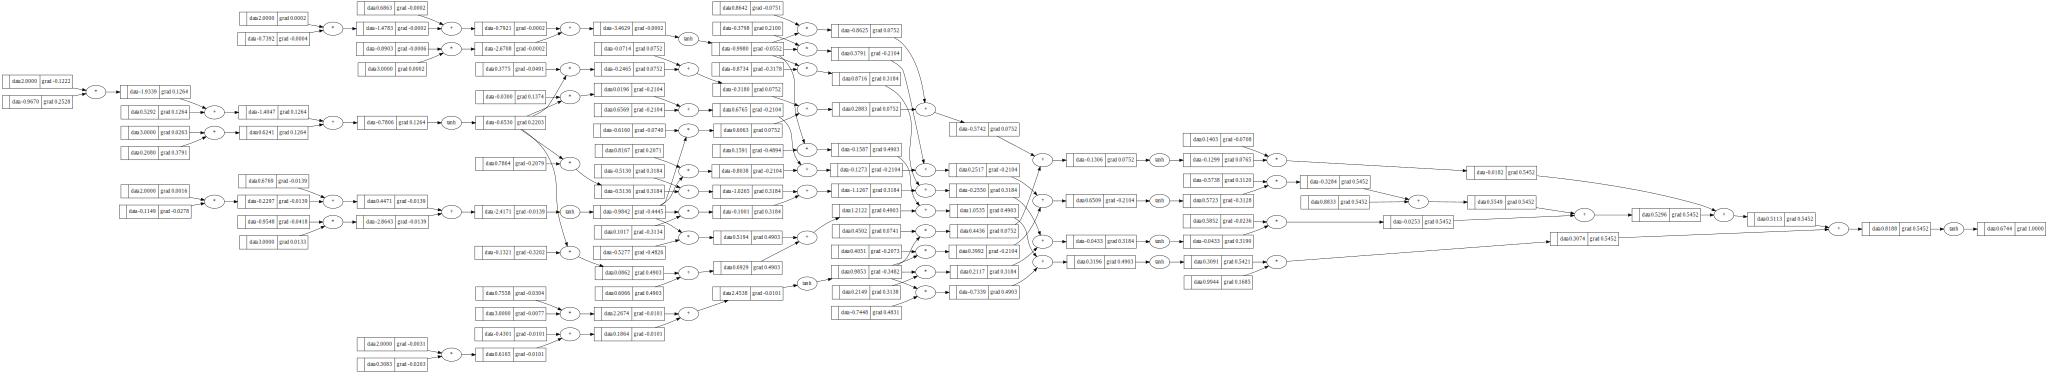

In [247]:
draw_dot(output)